In [24]:
import os

import streaming
from composer import DataSpec
from llmfoundry.utils.builders import build_dataloader
from transformers import AutoTokenizer, PreTrainedTokenizerBase

In [25]:
def get_data_loader(
    cfg: dict,
    tokenizer: PreTrainedTokenizerBase,
    device_train_batch_size: int,
) -> DataSpec:
    os.environ["S3_ENDPOINT_URL"] = "http://128.232.115.19:9000"

    train_loader = build_dataloader(
        cfg,
        tokenizer,
        device_train_batch_size,
    )
    return train_loader

In [26]:
tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM2-1.7B")
# tokenizer.pad_token = tokenizer.eos_token  # Set pad token to eos token

In [27]:
streaming.base.util.clean_stale_shared_memory()

streams = {
    "name": "text",
    "dataset": {
        "remote": "s3://smollm-corpus/shared/cosmo/client_0",
        "local": "/nfs-share/datasets/photon/dataset_cache/smollm-corpus-shared/cosmo/client_0",
        "split": "train",
        "proportion": "1",
        "max_seq_len": 2048,
        "cache_limit": None,
    },
    "num_workers": 4,
    "drop_last": True,
}
train_dataloader = get_data_loader(
    streams,
    tokenizer,
    device_train_batch_size=32,
)

In [28]:
sample = next(iter(train_dataloader.dataloader))

/nfs-share/pa511/code_bases/dyna_project/dyna/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [29]:
print(sample.keys())
print(sample["input_ids"].shape)
print(sample["labels"].shape)
print(sample["total_tokens"])
print(sample["loss_generating_tokens"])

dict_keys(['input_ids', 'labels', 'total_tokens', 'loss_generating_tokens'])
torch.Size([32, 2048])
torch.Size([32, 2048])
[2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048]
[tensor(2047), tensor(2047), tensor(2047), tensor(2047), tensor(2047), tensor(2047), tensor(2047), tensor(2047), tensor(2047), tensor(2047), tensor(2047), tensor(2047), tensor(2047), tensor(2047), tensor(2047), tensor(2047), tensor(2047), tensor(2047), tensor(2047), tensor(2047), tensor(2047), tensor(2047), tensor(2047), tensor(2047), tensor(2047), tensor(2047), tensor(2047), tensor(2047), tensor(2047), tensor(2047), tensor(2047), tensor(2047)]


In [30]:
import torch


def get_attention_mask_for_packed_sequence(input_ids, eos_token_id):
    """Create a causal attention mask for packed sequences.
    Each sequence in the batch should not attend to tokens from other sequences.
    """
    batch_size, seq_len = input_ids.shape

    # Create causal mask for each sample in the batch
    attention_masks = []

    for batch_idx in range(batch_size):
        x = input_ids[batch_idx]
        T = x.size(0)

        # Find EOS token positions
        eos_positions = (x == eos_token_id).nonzero(as_tuple=True)[0]
        print("x: ", x)
        print("eos id:", eos_token_id)
        if len(eos_positions) == 0:
            # No EOS tokens found, treat as single sequence
            mask = torch.tril(torch.ones(T, T, dtype=torch.bool))
        else:
            # Create base causal mask
            mask = torch.tril(torch.ones(T, T, dtype=torch.bool))

            # Add sequence boundaries
            sequence_starts = torch.cat([torch.tensor([0]), eos_positions + 1])
            sequence_ends = torch.cat([eos_positions, torch.tensor([T - 1])])

            print(sequence_starts, sequence_ends)

            # Mask out attention between different sequences
            for i, (start, end) in enumerate(
                zip(sequence_starts, sequence_ends, strict=False)
            ):
                if i < len(sequence_starts) - 1:  # Not the last sequence
                    # Tokens in current sequence shouldn't attend to future sequences
                    mask[start : end + 1, end + 1 :] = False
                    # Tokens in future sequences shouldn't attend to current sequence
                    mask[end + 1 :, start : end + 1] = False

        attention_masks.append(mask)

    return torch.stack(attention_masks)


def visualize_attention_mask(mask, tokenizer, input_ids, max_display=2048):
    """Helper function to visualize the attention mask"""
    import matplotlib.pyplot as plt

    # Only show first max_display tokens for readability
    display_len = min(max_display, mask.shape[-1])
    mask_subset = mask[0, :display_len, :display_len]

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(mask_subset.float(), cmap="Blues", aspect="equal")

    # Add token labels if provided
    if input_ids is not None:
        tokens = tokenizer.convert_ids_to_tokens(input_ids[0, :display_len])
        ax.set_xticks(range(display_len))
        ax.set_yticks(range(display_len))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax.set_title("Causal Attention Mask for Packed Sequence")
    ax.set_xlabel("Key Positions")
    ax.set_ylabel("Query Positions")
    plt.tight_layout()
    plt.show()


def visualize_position_mask(mask, max_display=2048):
    """Helper function to visualize the attention mask"""
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(mask[0].float())

    plt.tight_layout()
    plt.show()


def generate_source_len_mask(attention_mask):
    """Generate source length mask with position indices for each sequence."""
    batch_size, seq_len, _ = attention_mask.shape

    # Initialize position mask
    position_mask = torch.zeros(
        batch_size, seq_len, dtype=torch.long, device=attention_mask.device
    )

    for batch_idx in range(batch_size):
        mask = attention_mask[batch_idx]

        # Find where attention is allowed (causal mask pattern)
        # For each position, count how many previous positions it can attend to
        for pos in range(seq_len):
            # Count valid positions this token can attend to (including itself)
            valid_positions = mask[pos, : pos + 1].sum().item()
            position_mask[batch_idx, pos] = valid_positions - 1  # 0-indexed positions
    torch.set_printoptions(profile="full")
    print(position_mask)
    torch.set_printoptions(profile="default")

    return position_mask

x:  tensor([  0,   0, 533,  ...,  42, 198, 198])
eos id: 0
tensor([   0,    1,    2,  718,  719,  720,  721, 1439, 1440, 1441, 1442]) tensor([   0,    1,  717,  718,  719,  720, 1438, 1439, 1440, 1441, 2047])
x:  tensor([ 2931,  5104, 31171,  ..., 10033,  2684,   338])
eos id: 0
tensor([   0,  239,  240,  241,  242, 1207, 1208, 1209, 1210, 1884, 1885, 1886,
        1887]) tensor([ 238,  239,  240,  241, 1206, 1207, 1208, 1209, 1883, 1884, 1885, 1886,
        2047])
x:  tensor([16445,   351,   701,  ...,  3847,   351,   253])
eos id: 0
tensor([   0,  518,  519,  520,  521, 1207, 1208, 1209, 1210, 1870, 1871, 1872,
        1873]) tensor([ 517,  518,  519,  520, 1206, 1207, 1208, 1209, 1869, 1870, 1871, 1872,
        2047])
x:  tensor([ 7136,   284,  1692,  ..., 13980,  1147,    43])
eos id: 0
tensor([   0,  476,  477,  478,  479, 1824, 1825, 1826, 1827]) tensor([ 475,  476,  477,  478, 1823, 1824, 1825, 1826, 2047])
x:  tensor([ 4219,  4108,  4158,  ...,  6008, 11470, 16774])
eos id: 0
t

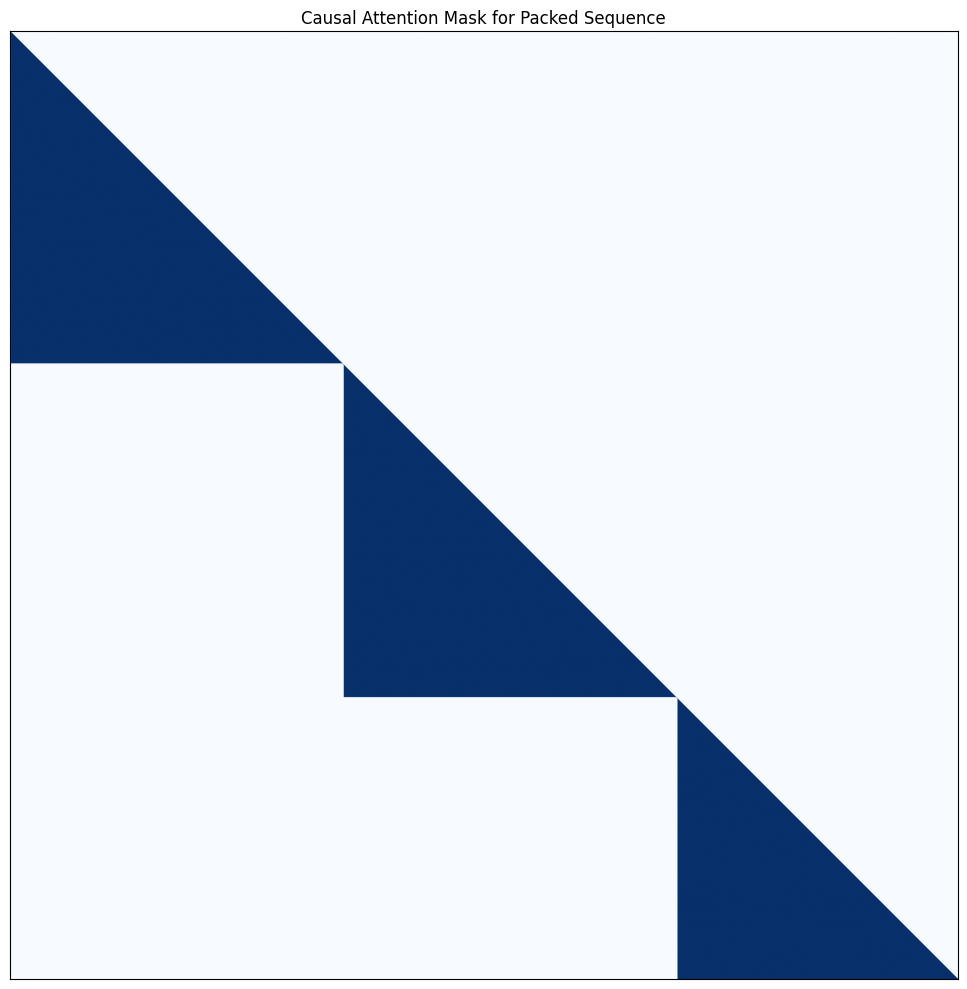

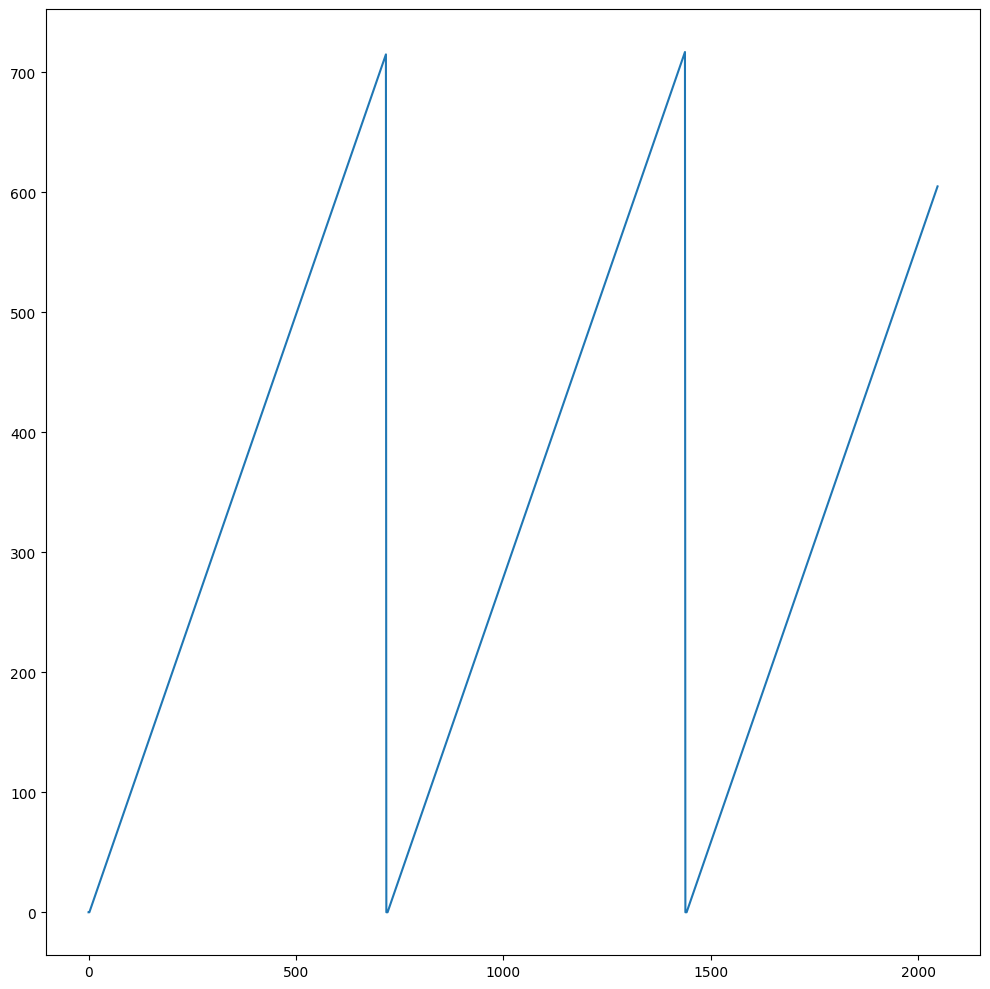

In [31]:
# Generate attention mask for the sample
attention_mask = get_attention_mask_for_packed_sequence(
    sample["input_ids"], tokenizer.eos_token_id
)
pos_mask = generate_source_len_mask(attention_mask)

# Decode and show first sequence for context
first_sequence = sample["input_ids"][0]
decoded_text = tokenizer.decode(first_sequence)  # First 100 tokens
print(f"\nFirst 100 tokens decoded: {decoded_text[:200]}...")


print(attention_mask.shape)
# Visualize the attention mask
visualize_attention_mask(attention_mask, tokenizer, sample["input_ids"])
visualize_position_mask(pos_mask)

In [32]:
# Test with a simpler example to verify correctness
def test_packed_sequence_mask():
    """Test the mask function with a known packed sequence"""
    # Create a simple test case with known sequences
    # Sequence 1: [1, 2, 3, EOS] Sequence 2: [4, 5, EOS] Sequence 3: [6, 7, 8, EOS]
    test_input = torch.tensor(
        [
            [
                1,
                2,
                3,
                tokenizer.eos_token_id,
                4,
                5,
                tokenizer.eos_token_id,
                6,
                7,
                8,
                tokenizer.eos_token_id,
                0,
                0,
                0,
                0,
            ]
        ]
    )

    mask = get_attention_mask_for_packed_sequence(test_input, tokenizer)

    print("Test input shape:", test_input.shape)
    print("Test mask shape:", mask.shape)
    print("Test input:", test_input[0])
    print("EOS positions:", torch.where(test_input[0] == tokenizer.eos_token_id)[0])

    # Check specific positions
    print("\nMask verification:")
    print("Token 2 can attend to token 0 (same seq):", mask[0, 2, 0].item())
    print("Token 2 cannot attend to token 4 (diff seq):", not mask[0, 2, 4].item())
    print("Token 5 can attend to token 4 (same seq):", mask[0, 5, 4].item())
    print("Token 5 cannot attend to token 0 (diff seq):", not mask[0, 5, 0].item())

    return mask


test_mask = test_packed_sequence_mask()

AttributeError: 'bool' object has no attribute 'nonzero'